In [69]:
# load wandb artifact (trained model state)
import wandb
run = wandb.init()
artifact = run.use_artifact('wittgensteinian/Parameter-Efficient-Tuning/LoRA_BERT:v0', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wittgensteinian (use `wandb login --relogin` to force relogin)


In [4]:
# load base model and tokenizer
from transformers import BertForSequenceClassification, BertTokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

AttributeError: module 'requests' has no attribute 'exceptions'

In [ ]:
import torch

In [4]:
# fine-tune
model.load_state_dict(torch.load('artifacts/finetuned_BERT:v7/summer-sea-11.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
# adapter
model.load_adapter('artifacts/Adapter_BERT:v5/kr3', set_active=True)

'kr3'

In [3]:
# lora
# strict set to False because we only load the LoRA matrices.
model.load_state_dict(torch.load('artifacts/LoRA_BERT:v0/LoRA-8.pth', map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.ou

In [5]:
# env check
import transformers
if 'AdapterConfig' in dir(transformers):
    print('Current transformer package is adapter-transformer.')
else:
    print('Current transformer package is vanilla transformer.')

Current transformer package is vanilla transformer.


In [6]:
# load the dataset
from datasets import load_dataset

kr3 = load_dataset("Wittgensteinian/KR3", name='kr3', split='train')
kr3 = kr3.remove_columns(['__index_level_0__'])

Using custom data configuration Wittgensteinian--KR3-9f7e41b8ab859e44


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/vscode/.cache/huggingface/datasets/parquet/Wittgensteinian--KR3-9f7e41b8ab859e44/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


In [91]:
# example input and forward pass
i = 1231
review = kr3['Review'][i:i+1]
true_label = kr3['Rating'][i:i+1]
tokenized = tokenizer(review)
input_tensors = {k:torch.tensor(v) for k,v in tokenized.items()}
output = model(**input_tensors, output_attentions=True) # outputs.attention is a tuple, each entry a 4D attn tensor for each layer

In [92]:
# review natural text
review

['무료주차된다. 반찬이 맛있담. 주차 발레 해준다. 식사시간에 대기 줄어 길다']

In [93]:
# inference result
'Predict:', output.logits.argmax(), 'True:', true_label

('Predict:', tensor(1), 'True:', [1])

In [94]:
# full attention weights
attn_weights = torch.stack([attn for attn in output.attentions], dim=1)
attn_weights.size() # (batch_size, num_layers, num_heads, seq_len, seq_len)

torch.Size([1, 12, 12, 33, 33])

<AxesSubplot:>

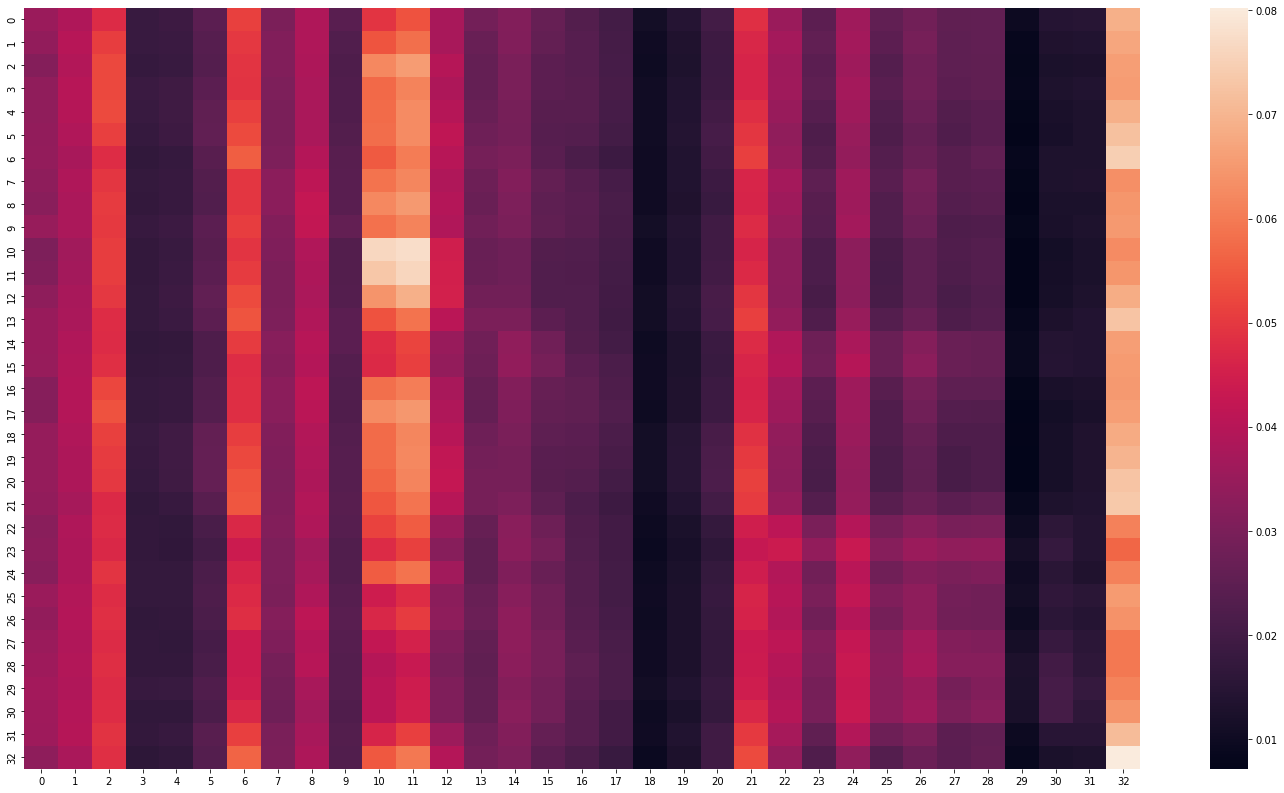

In [95]:
# heatmap for full attn map, mean over head
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25,14))
l = -4 # last layer, or 4th layer from the back?
sns.heatmap(attn_weights[0,l,:,:,:].mean(0).detach().numpy(), ax=ax) 

In [122]:
# per-token attn weight indexing following Chrysostomou et al., 2021 and Jain et al., 2020
# see src/models/bert.py line 71 in https://github.com/GChrysostomou/saloss

attention = attn_weights[0,-4,:,0,:].mean(0).detach() # layer, mean over head, attn w.r.t. <CLS>
print(attention.size())

torch.Size([33])


In [123]:
attention # per token

tensor([0.0352, 0.0387, 0.0476, 0.0181, 0.0189, 0.0243, 0.0514, 0.0302, 0.0386,
        0.0242, 0.0494, 0.0538, 0.0375, 0.0288, 0.0312, 0.0263, 0.0228, 0.0202,
        0.0110, 0.0143, 0.0200, 0.0484, 0.0353, 0.0246, 0.0362, 0.0256, 0.0284,
        0.0252, 0.0256, 0.0097, 0.0145, 0.0147, 0.0690])

In [124]:
# exclude special tokens: [CLS]-101, [SEP]-102, [PAD]-0

# assert
assert len(tokenized['input_ids'][0]) == len(attention)

# bool array for mask
special_token_mask = torch.zeros_like(attention).bool()

# iterate over each tokens. If token is one of special tokens, change the mask value.
special_tokens = [0, 101, 102]
for i, input_id in enumerate(tokenized['input_ids']):
    if input_id in special_tokens:
        special_token_mask[i] = 1

# normalize over unmasked tokens
attention = torch.masked_fill(attention, special_token_mask, 0)
attention /= attention.sum(dim=-1)


In [125]:
attention # per token, normalized

tensor([0.0352, 0.0387, 0.0476, 0.0181, 0.0189, 0.0243, 0.0514, 0.0302, 0.0386,
        0.0242, 0.0494, 0.0538, 0.0375, 0.0288, 0.0312, 0.0263, 0.0228, 0.0202,
        0.0110, 0.0143, 0.0200, 0.0484, 0.0353, 0.0246, 0.0362, 0.0256, 0.0284,
        0.0252, 0.0256, 0.0097, 0.0145, 0.0147, 0.0690])

In [126]:
# attention score per word, computed by summing scores for tokens in the word
words = review[0].split(' ')
attention_per_word = torch.zeros(len(words))
tokens_per_word = []

# start slicing index by 1
# why not 0? Because first token is the [CLS]. cf) We don't have [SEP] in the middle of the input, so we do not consider that.
i = 1

for j, word in enumerate(words):
    # number of tokens in the word
    num_tokens = len(tokenizer.tokenize(word))

    # slice the attention by num_tokens
    tokens_per_word.append(attention[i:i+num_tokens])
    # sum over tokens to obtain attention per word
    sum = tokens_per_word[j].sum(dim=-1)
    attention_per_word[j] = sum
    i += num_tokens
    

In [127]:
attention_per_word

tensor([0.1991, 0.0930, 0.1695, 0.0575, 0.0431, 0.0937, 0.1218, 0.0536, 0.0353,
        0.0293])

## ERASER

In [128]:
ratio = 0.2
rationale_idxs = attention_per_word.argsort(descending=True)[:int(len(attention_per_word)*ratio)]
rationale_idxs

tensor([0, 2])

In [129]:
review

['무료주차된다. 반찬이 맛있담. 주차 발레 해준다. 식사시간에 대기 줄어 길다']

In [130]:
rationale = [] # words in the rationale, ordered (for sufficiency eval)
unrationale = [] # words not in the rationale, ordered (for completeness evla)

for i, word in enumerate(words):
    if i in rationale_idxs:
        rationale.append(word)
    else:
        unrationale.append(word)

In [131]:
rationale_text = ' '.join(rationale) # words in the list concated to a sentence
unrationale_text = ' '.join(unrationale)

print(rationale_text, '\n')
print(unrationale_text, '\n')
print(review)

무료주차된다. 맛있담. 

반찬이 주차 발레 해준다. 식사시간에 대기 줄어 길다 

['무료주차된다. 반찬이 맛있담. 주차 발레 해준다. 식사시간에 대기 줄어 길다']


In [132]:
tokenized_rationale = tokenizer(rationale_text)
input_tensors = {k:torch.tensor([v]) for k,v in tokenized_rationale.items()} # [v] for pseudo-batch
rationale_output = model(**input_tensors, output_attentions=True)
rationale_prediction = torch.softmax(rationale_output.logits.detach(), dim=-1)[0][1].item()
rationale_prediction

0.9992024302482605

In [133]:
tokenized_unrationale = tokenizer(unrationale_text)
input_tensors = {k:torch.tensor([v]) for k,v in tokenized_unrationale.items()} # [v] for pseudo-batch
unrationale_output = model(**input_tensors, output_attentions=True)
unrationale_prediction = torch.softmax(unrationale_output.logits.detach(), dim=-1)[0][1].item()
unrationale_prediction

0.9740928411483765

In [134]:
original_prediction = torch.softmax(output.logits.detach(), dim=-1)[0][1].item()
original_prediction

0.9991903901100159

In [137]:
output.logits.detach().size()

torch.Size([1, 2])

## Decision Flip (Serrano & Smith 2019)

In [62]:
original_prediction = output.logits.argmax().item()
original_prediction

1

In [63]:
attention.argsort(descending=True)[0]

tensor(211)

In [237]:
for i in range(attention.size(-1)):
    zeroed_idxs = attention.argsort(descending=True)[:i+1] # zero the top i tokens
    
    # rebuild input in which some of the tokens are zeroed.
    flip_tokenized = {}
    for key, value in tokenized.items(): # keys are 'input_ids', 'token_type_ids', and 'attention_mask'
        new_value = []
        for i, x in enumerate(value): 
            if i not in zeroed_idxs:
                new_value.append(x)
        flip_tokenized[key] = new_value

    # forward
    flip_output = model(**{k:torch.tensor([v]) for k,v in flip_tokenized.items()})
    if original_prediction != flip_output.logits.argmax().item():
        print(f"Decision flipped at {i/attention.size(-1)}, {i}/{attention.size(-1)}")
        break
    


Decision flipped at 0.9954545454545455, 219/220
